# Importing

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score
)
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


# Read Data

In [16]:
df=pd.read_csv ('/content/synthetic_fraud_dataset 2(1).csv')
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


# Checking Null Values Dropping Columns

In [17]:
#Missing values in data
null_counts = df.isnull().sum()
print(null_counts)


#dropping columns
df.drop(columns=["Transaction_ID", "User_ID"], inplace=True)

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64


In [18]:
# Feature Engineering

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Ratio of transaction to balance (normalize transaction size)
df['Transaction_to_Balance_Ratio'] = df['Transaction_Amount'] / (df['Account_Balance'] + 1e-5)

# Failed transaction rate (failed out of total attempts in past 7 days)
df['Failed_Transaction_Rate_7d'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1e-5)

# The transaction amount compared to the average amount over 7 d
df['Amount_vs_7d_avg'] = df['Transaction_Amount'] / (df['Avg_Transaction_Amount_7d'] + 1e-5)

# How far the transaction took place from registered location
df['Transaction_Distance_Bucket'] = pd.cut(df['Transaction_Distance'],
                                           bins=[-1, 500, 1500, 3000, np.inf],
                                           labels=['Local', 'Near', 'Far', 'Very Far'])


# Card age buckets (convert months into bins: new, mid, old)
df['Card_Age_Bucket'] = pd.cut(df['Card_Age'], bins=[-1, 24, 72, np.inf], labels=['New', 'Mid', 'Old'])

# How strong the authentication is
auth_map = {
    'Biometric': 3,
    'PIN': 2,
    'OTP': 1.5,  # stronger than OTP, weaker than PIN
    'Password': 1
}
df['Auth_Strength'] = df['Authentication_Method'].map(auth_map)



# Visualization

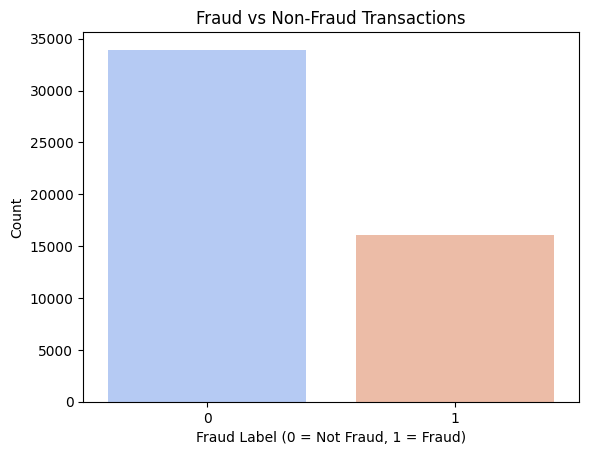

In [19]:
# fraud count
sns.countplot(x=df['Fraud_Label'], palette='coolwarm')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud Label (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()


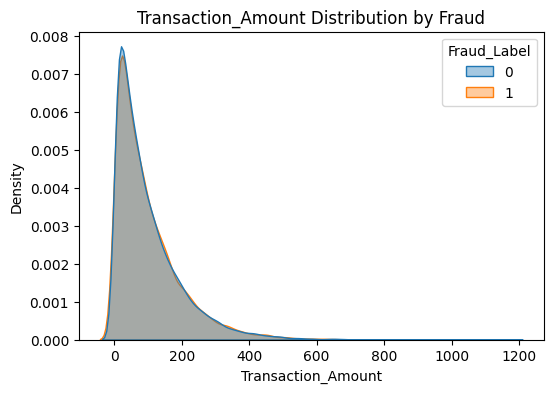

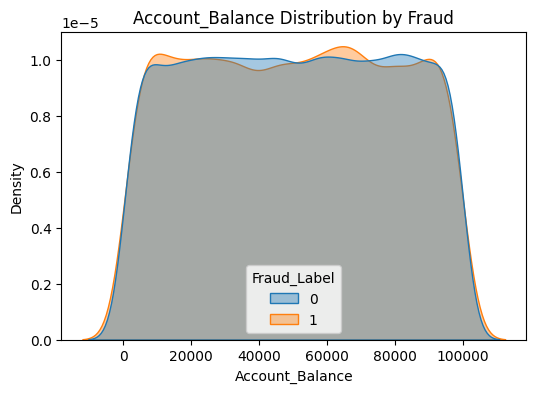

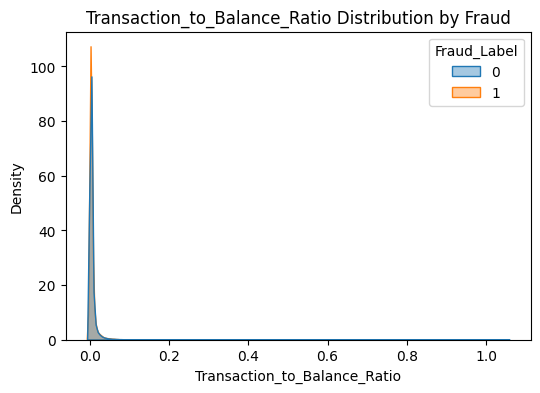

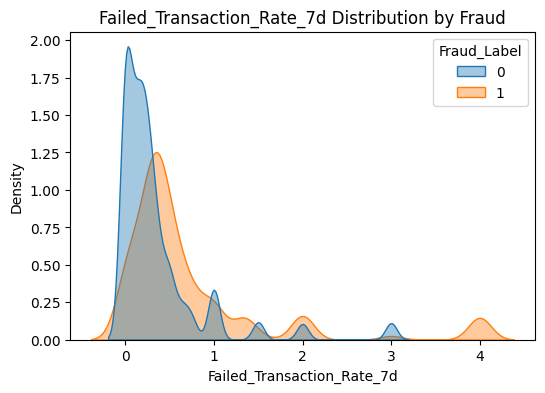

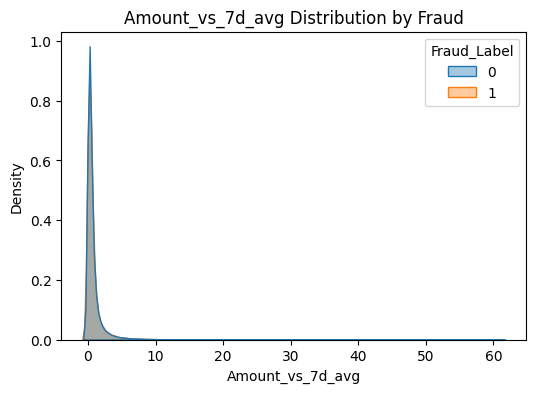

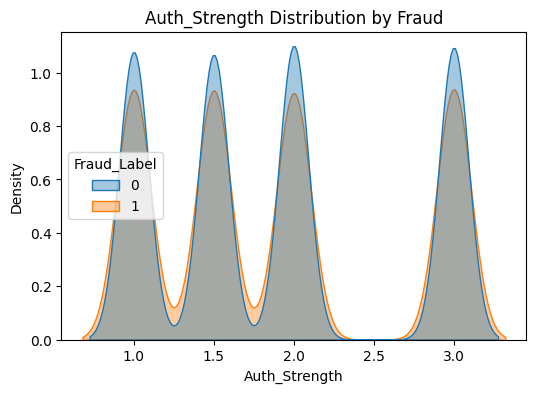

In [20]:
numeric_features = [
    'Transaction_Amount',
    'Account_Balance',
    'Transaction_to_Balance_Ratio',
    'Failed_Transaction_Rate_7d',
    'Amount_vs_7d_avg',
    'Auth_Strength'
]

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=feature, hue='Fraud_Label', fill=True, common_norm=False, alpha=0.4)
    plt.title(f'{feature} Distribution by Fraud')
    plt.show()


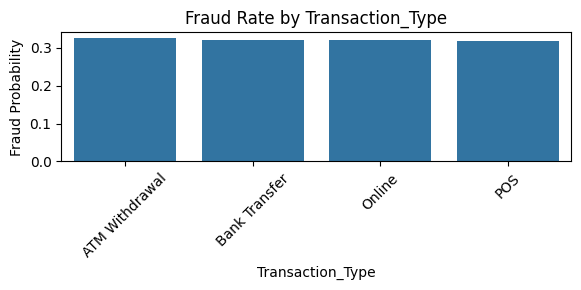

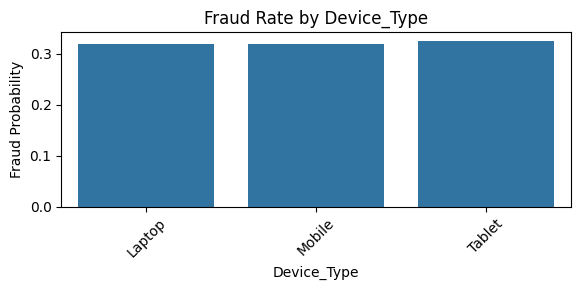

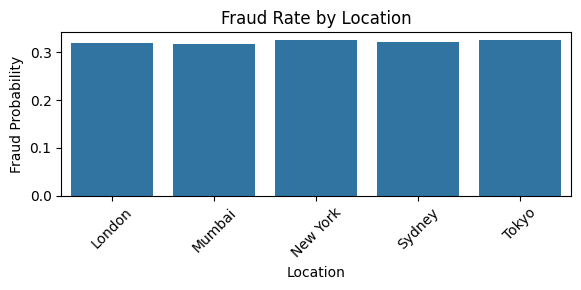

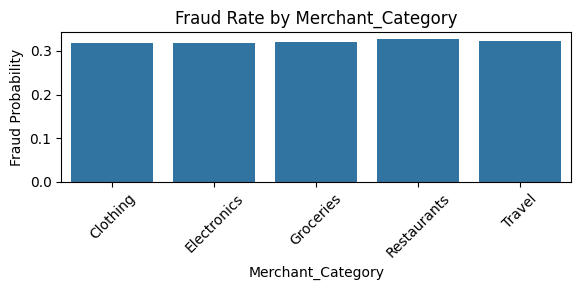

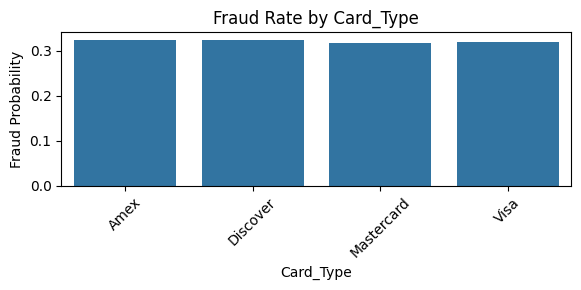

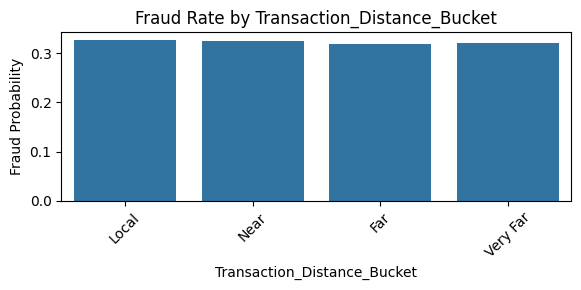

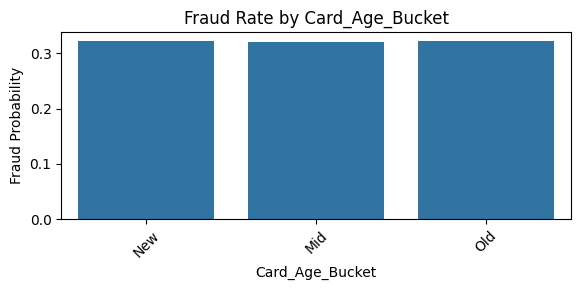

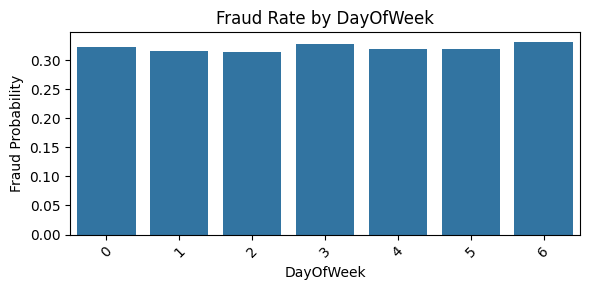

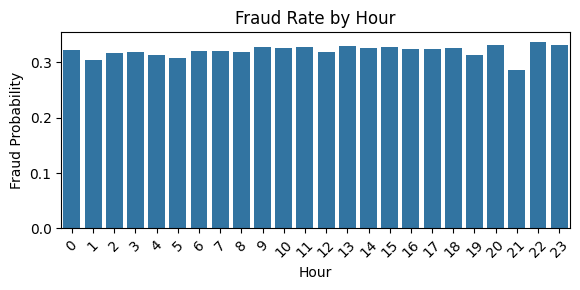

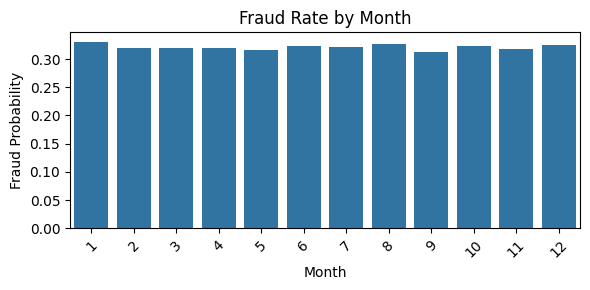

In [21]:
categorical_features = [
    'Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type',
    'Transaction_Distance_Bucket', 'Card_Age_Bucket', 'DayOfWeek', 'Hour', 'Month'
]

for col in categorical_features:
    plt.figure(figsize=(6, 3))
    fraud_rate = df.groupby(col)['Fraud_Label'].mean()
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel('Fraud Probability')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


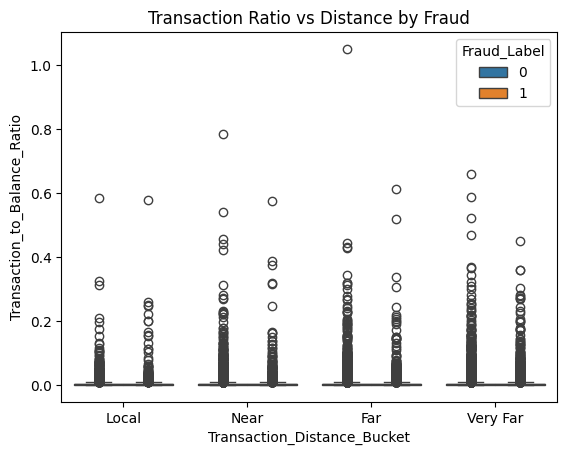

In [22]:
sns.boxplot(x='Transaction_Distance_Bucket', y='Transaction_to_Balance_Ratio', hue='Fraud_Label', data=df)
plt.title('Transaction Ratio vs Distance by Fraud')
plt.show()


In [23]:
# Updated list of categorical columns to encode
categorical_cols = [
    'Transaction_Type',
    'Device_Type',
    'Location',
    'Merchant_Category',
    'Card_Type',
    'Transaction_Distance_Bucket',
    'Card_Age_Bucket'
]

# Apply LabelEncoder to all updated categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Binary columns already fine
binary_cols = ['IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Is_Weekend']
df[binary_cols] = df[binary_cols].astype(int)

# Drop the leakage-prone column
df.drop(columns=["Risk_Score", "Authentication_Method","Timestamp","Card_Age","Transaction_Distance"], inplace=True)

# Confirm everything is clean
print("Processed DataFrame:")
print(df.dtypes)
df.head()

Processed DataFrame:
Transaction_Amount              float64
Transaction_Type                  int64
Account_Balance                 float64
Device_Type                       int64
Location                          int64
Merchant_Category                 int64
IP_Address_Flag                   int64
Previous_Fraudulent_Activity      int64
Daily_Transaction_Count           int64
Avg_Transaction_Amount_7d       float64
Failed_Transaction_Count_7d       int64
Card_Type                         int64
Is_Weekend                        int64
Fraud_Label                       int64
Hour                              int32
DayOfWeek                         int32
Month                             int32
Transaction_to_Balance_Ratio    float64
Failed_Transaction_Rate_7d      float64
Amount_vs_7d_avg                float64
Transaction_Distance_Bucket       int64
Card_Age_Bucket                   int64
Auth_Strength                   float64
dtype: object


,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,...,Fraud_Label,Hour,DayOfWeek,Month,Transaction_to_Balance_Ratio,Failed_Transaction_Rate_7d,Amount_vs_7d_avg,Transaction_Distance_Bucket,Card_Age_Bucket,Auth_Strength
0,39.79,3,93213.17,0,3,4,0,0,7,437.63,...,0,19,0,8,0.000427,0.428571,0.090922,2,0,3.0
1,1.19,1,75725.25,1,2,0,0,0,13,478.76,...,1,4,2,6,0.000016,0.307692,0.002486,0,2,1.0
2,28.96,2,1588.96,2,1,3,0,0,14,50.01,...,1,15,1,6,0.018226,0.285714,0.579084,0,2,3.0
3,254.32,0,76807.20,2,2,0,0,0,8,182.48,...,1,0,3,12,0.003311,0.499999,1.393687,2,2,1.5
4,31.28,3,92354.66,1,1,1,0,1,14,328.69,...,1,23,5,11,0.000339,0.285714,0.095166,2,2,1.0


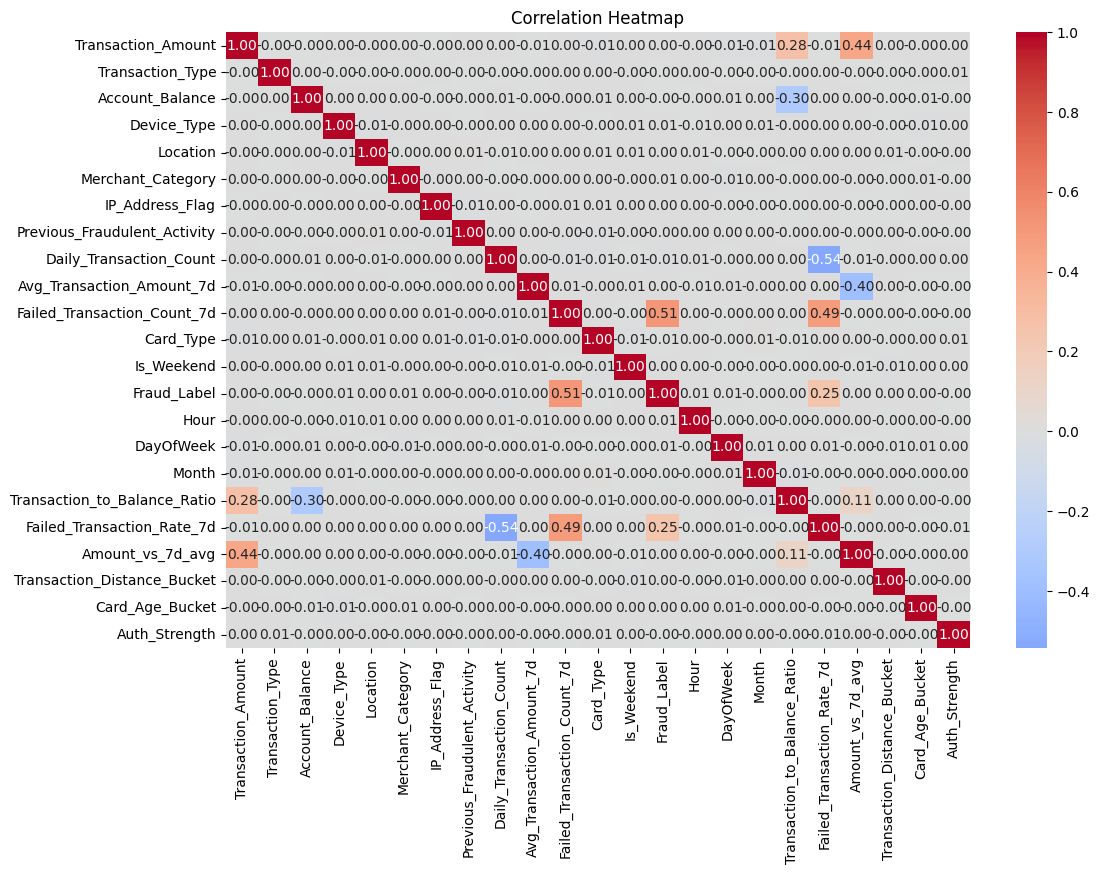

In [24]:
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


#Scaling


In [25]:
# Separate features and target
X = df.drop(columns=['Fraud_Label'])
y = df['Fraud_Label']

# Train-test split (stratify keeps fraud ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize scaler
scaler = StandardScaler()

# Fit only on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Pipeline

In [26]:
model_list = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Models that need StandardScaler
scale_models = ['Logistic Regression', 'SVM', 'Naive Bayes']

# Dictionary to store all pipelines
pipelines = {}

# Create pipelines using a loop
for name, model in model_list:
    if name in scale_models:
        pipelines[name] = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
    else:
        pipelines[name] = Pipeline([
            ('clf', model)
        ])


# Running / Evaluating

In [27]:
for name, model in pipelines.items():
    print(f"\nTraining and Evaluating: {name}")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = model.decision_function(X_test)

    # Print evaluation metrics
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("F1 Score:", round(f1_score(y_test, y_pred), 4))
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Training and Evaluating: Logistic Regression
Accuracy: 0.8739
Precision: 0.9784
Recall: 0.6212
F1 Score: 0.7599
ROC AUC: 0.8031
Confusion Matrix:
 [[6743   44]
 [1217 1996]]

Training and Evaluating: Decision Tree
Accuracy: 0.7747
Precision: 0.6406
Recall: 0.6807
F1 Score: 0.66
ROC AUC: 0.7499
Confusion Matrix:
 [[5560 1227]
 [1026 2187]]

Training and Evaluating: Random Forest
Accuracy: 0.8772
Precision: 1.0
Recall: 0.6178
F1 Score: 0.7638
ROC AUC: 0.8119
Confusion Matrix:
 [[6787    0]
 [1228 1985]]

Training and Evaluating: SVM
Accuracy: 0.8755
Precision: 0.993
Recall: 0.6169
F1 Score: 0.761
ROC AUC: 0.8141
Confusion Matrix:
 [[6773   14]
 [1231 1982]]

Training and Evaluating: Naive Bayes
Accuracy: 0.8305
Precision: 0.7935
Recall: 0.6387
F1 Score: 0.7077
ROC AUC: 0.7701
Confusion Matrix:
 [[6253  534]
 [1161 2052]]

Training and Evaluating: XGBoost
Accuracy: 0.8755
Precision: 0.9881
Recall: 0.62
F1 Score: 0.7619
ROC AUC: 0.8051
Confusion Matrix:
 [[6763   24]
 [1221 1992]]


# Hyperparameter Tuning


In [28]:
xgb_params = {
    'clf__n_estimators': randint(100, 300),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.2),
    'clf__subsample': uniform(0.7, 0.3),
    'clf__colsample_bytree': uniform(0.7, 0.3)
}

xgb_pipeline = pipelines['XGBoost']

# RandomizedSearchCV for tuning
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best XGBoost Params:", random_search.best_params_)
print("Best F1 Score (CV):", round(random_search.best_score_, 4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params: {'clf__colsample_bytree': np.float64(0.9134025858245949), 'clf__learning_rate': np.float64(0.16803510810624114), 'clf__max_depth': 5, 'clf__n_estimators': 104, 'clf__subsample': np.float64(0.9778902635540047)}
Best F1 Score (CV): 0.7654




# Evaluating Tuned Model


🎯 Final Evaluation on Test Set after Tuning:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6787
           1       1.00      0.62      0.76      3213

    accuracy                           0.88     10000
   macro avg       0.92      0.81      0.84     10000
weighted avg       0.90      0.88      0.87     10000

ROC AUC: 0.8075


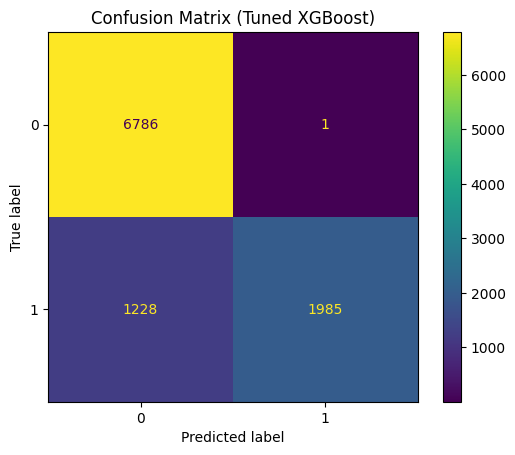

In [29]:
y_pred = random_search.predict(X_test)
y_proba = random_search.predict_proba(X_test)[:, 1]

print("🎯 Final Evaluation on Test Set after Tuning:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test)
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.show()